### I work through the PySpark tutorial from Datacamp by Karlijn Willems

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


In [2]:
from pyspark.ml.linalg import DenseVector
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import RandomForestRegressor

In [3]:
spark = SparkSession.builder.master("local").appName("Linear Regression Model")\
        .getOrCreate()

In [4]:
sc = spark.sparkContext

### Load the California Housing dataset in the appropriate folder

In [110]:
rdd = sc.textFile("cal_housing\CaliforniaHousing\cal_housing.data")

In [111]:
header = sc.textFile("cal_housing\CaliforniaHousing\cal_housing.domain")
header.collect()

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

In [ ]:
rdd.take(5)
# Looking at the data below, we need to clean it. 

In [112]:
def clean_lines(my_rdd): 
    '''loads in a line of RDD and splits by comma'''
    return my_rdd.map(lambda line: line.split(","))
rdd = clean_lines(rdd)

In [8]:
rdd.take(2)

[['-122.230000',
  '37.880000',
  '41.000000',
  '880.000000',
  '129.000000',
  '322.000000',
  '126.000000',
  '8.325200',
  '452600.000000'],
 ['-122.220000',
  '37.860000',
  '21.000000',
  '7099.000000',
  '1106.000000',
  '2401.000000',
  '1138.000000',
  '8.301400',
  '358500.000000']]

#### Since RDDs are unweildy, we convert them to dataframes

In [113]:
# First get all the column names out as a list. Once you get a df, you can use df.columns; just wanted to experiment with 
# RDD manipulation
new_header = header.map(lambda line: line.split(':')).map(lambda x: x[0])
COLUMNS = new_header.collect()

In [114]:
from pyspark.sql import Row
df = rdd.map(lambda line: Row(longitude= line[0],
                             latitude = line[1],
                             housingMedianAge = line[2],
                             totalRooms = line[3],
                             totalBedRooms =line[4],
                             population = line[5],
                             households = line[6],
                             medianIncome = line[7],
                             medianHouseValue = line[8])).toDF()

In [115]:
df.show()

+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| households|housingMedianAge| latitude|  longitude|medianHouseValue|medianIncome| population|totalBedRooms| totalRooms|
+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| 126.000000|       41.000000|37.880000|-122.230000|   452600.000000|    8.325200| 322.000000|   129.000000| 880.000000|
|1138.000000|       21.000000|37.860000|-122.220000|   358500.000000|    8.301400|2401.000000|  1106.000000|7099.000000|
| 177.000000|       52.000000|37.850000|-122.240000|   352100.000000|    7.257400| 496.000000|   190.000000|1467.000000|
| 219.000000|       52.000000|37.850000|-122.250000|   341300.000000|    5.643100| 558.000000|   235.000000|1274.000000|
| 259.000000|       52.000000|37.850000|-122.250000|   342200.000000|    3.846200| 565.000000|   280.000000|1627.000000|
| 193.000000|       52.000000|37

In [117]:
df.printSchema()
# need to cast string types into float32 or int as needed

root
 |-- households: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- population: string (nullable = true)
 |-- totalBedRooms: string (nullable = true)
 |-- totalRooms: string (nullable = true)



In [118]:
def cast_columns(df, names, newType):
    ''' cast the columns into type newType'''
    for name in names:
        df = df.withColumn(name, df[name].cast(newType))
    return df

In [119]:
df = cast_columns(df, COLUMNS, FloatType())

In [120]:
# Get some summary statistics
df.describe().show()

+-------+-----------------+------------------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|       households|  housingMedianAge|         latitude|          longitude|  medianHouseValue|      medianIncome|        population|    totalBedrooms|        totalRooms|
+-------+-----------------+------------------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|            20640|             20640|            20640|              20640|             20640|             20640|             20640|            20640|             20640|
|   mean|499.5396802325581|28.639486434108527|35.63186143109965|-119.56970444871473|206855.81690891474|3.8706710030346416|1425.4767441860465|537.8980135658915|2635.7630813953488|
| stddev|382.3297528316098| 12.58555761211163|2.135952380602968|  2.003531742932898|115395.61587441359|1.

# Data Exploration

#### It is obvious that certain variables are going to be correlated. For example look at the households and population columns

In [63]:
df.select('population', 'households').sort("population", ascending = False).show(10)

+----------+----------+
|population|households|
+----------+----------+
|   35682.0|    4769.0|
|   28566.0|    6082.0|
|   16305.0|    5358.0|
|   16122.0|    5189.0|
|   15507.0|    5050.0|
|   15037.0|    4072.0|
|   13251.0|    4339.0|
|   12873.0|    3931.0|
|   12427.0|    2826.0|
|   12203.0|    3701.0|
+----------+----------+
only showing top 10 rows



#### How correlated are the variables? 

In [16]:
# convert to vector column first - spark ml requires this before it can output correlations
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

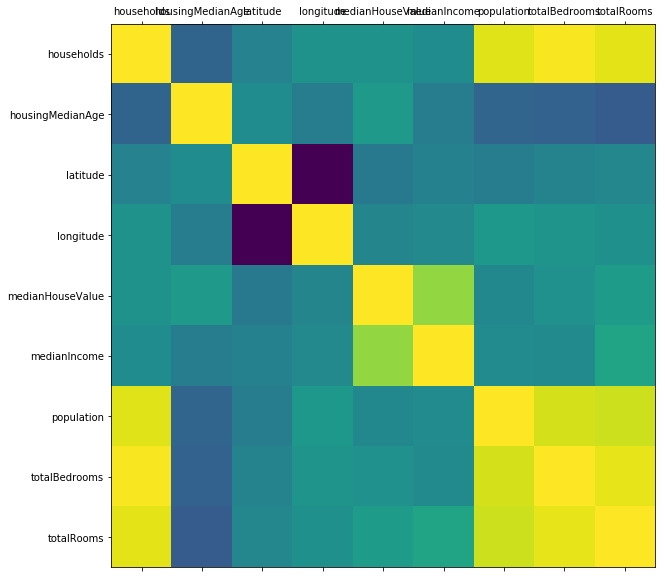

In [20]:
t = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(9, 9)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(t)
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.show()

#### Plot histograms and distributions of the data to look for skewness, trends and correlations. This solution is not scalable, but to make plots we have to take subsets of the Spark dataframe and convert to a pandas dataframe. This data is small enough that we can just convert the whole thing. 

In [121]:
attributes = ["medianHouseValue", "totalRooms", "households", "housingMedianAge", "medianIncome"]
df_to_pandas = df.toPandas()

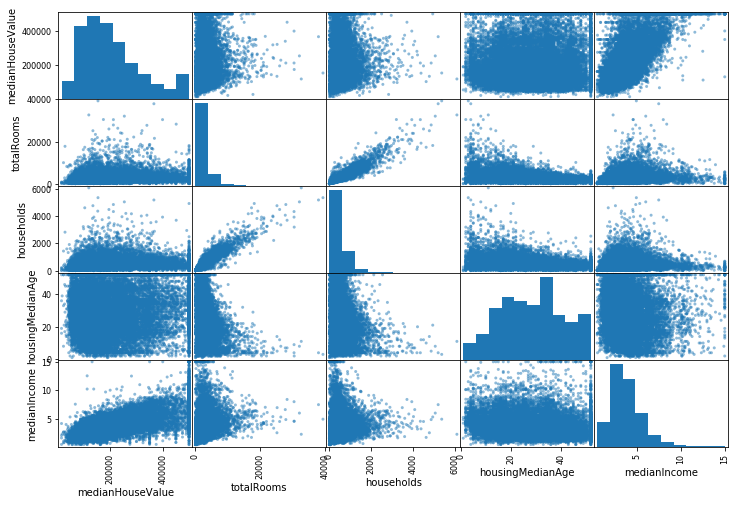

In [69]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_to_pandas[attributes], figsize = (12, 8))
plt.show()

#### Median income is strongly correlateed with House value. Except that there is a vertical line in the dataset -- very expensive house values around 500K seem to be owned by people of all income groups. It may be worth simply removing that dataset in order to make the model more predictive. Also households and rooms are highly correlated. Median age is also not a normal distribution. 

In [80]:
expensive_houses = df.filter(df.medianHouseValue > 500000)

In [82]:
expensive_houses.count()

965

#### There are about 965 rows that fall in this category. Let's just remove these. We're still left with about 20000.

In [122]:
df = df.filter(df.medianHouseValue < 500000)
df.count()

19648

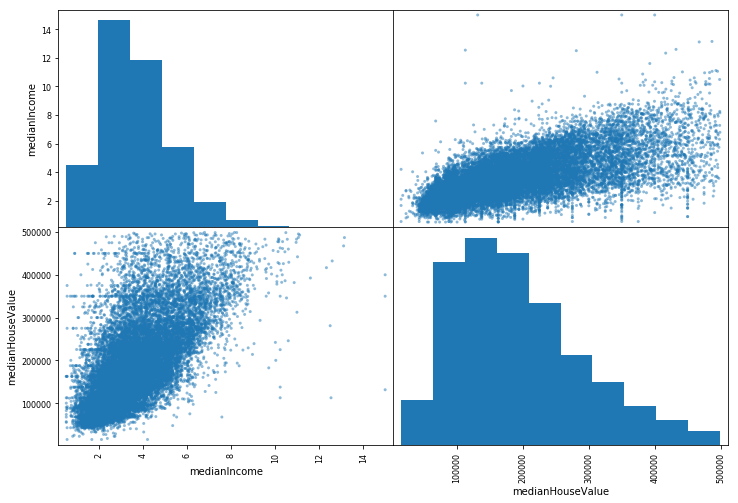

In [123]:
#### Remake the scatter plot from before.
df_to_pandas = df.toPandas()
scatter_matrix(df_to_pandas[['medianIncome', 'medianHouseValue']], figsize = (12, 8))
plt.show()

#### Given the presence of correlated features -- it may be useful to construct 3 new features: 
#### 1) Bedrooms/total rooms - as these basically have the same information. 
#### 2) population/Household
#### 3) Rooms/Household
#### We use these new features in our model

# Feature Engineering and Preprocessing

In [124]:
df = df.withColumn("bedroomsperhouse", col("totalBedrooms")/col("totalRooms")) \
                 .withColumn("roomsperhouse",col("totalRooms")/col("households"))\
                .withColumn("populationperhousehold", col("population")/col("households"))

In [125]:
# Next we also normalize the dependent variable to lie within reasonable values. Take log of Age variable.
df = df.withColumn("medianHouseValue", col("medianHouseValue")/100000)
df = df.withColumn("housingMedianAge", log(df["housingMedianAge"]))

In [126]:
df.first()

Row(households=126.0, housingMedianAge=3.713572066704308, latitude=37.880001068115234, longitude=-122.2300033569336, medianHouseValue=4.526, medianIncome=8.325200080871582, population=322.0, totalBedrooms=129.0, totalRooms=880.0, bedroomsperhouse=0.14659090909090908, roomsperhouse=6.984126984126984, populationperhousehold=2.5555555555555554)

In [ ]:
# Select the features to separate the indpeendent and dependent variables.
# Order the dataframe to have the dependent varialbe first followed by independent variables.

In [127]:
COLUMNS = ["medianHouseValue", "latitude", "longitude", "totalBedrooms", "totalRooms", "bedroomsperhouse", "roomsperhouse", "populationperhousehold",
           "households", "housingMedianAge", "population"]

df = df.select(COLUMNS)

In [128]:
input_data = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

data_df = spark.createDataFrame(input_data, ["label", "features"])

In [129]:
standardScaler = StandardScaler(inputCol = "features", outputCol = "features_scaled")
scaler= standardScaler.fit(data_df)
scaled_df = scaler.transform(data_df)

scaled_df.take(2)

[Row(label=4.526, features=DenseVector([37.88, -122.23, 129.0, 880.0, 0.1466, 6.9841, 2.5556, 126.0, 3.7136, 322.0]), features_scaled=DenseVector([17.6181, -60.9395, 0.3054, 0.4032, 2.5731, 3.0454, 0.2402, 0.3286, 6.5412, 0.2815])),
 Row(label=3.585, features=DenseVector([37.86, -122.22, 1106.0, 7099.0, 0.1558, 6.2381, 2.1098, 1138.0, 3.0445, 2401.0]), features_scaled=DenseVector([17.6088, -60.9345, 2.6182, 3.2529, 2.7347, 2.7201, 0.1983, 2.9682, 5.3627, 2.0986]))]

# Modeling

In [130]:
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed = 42)

In [131]:
lr = LinearRegression(labelCol = "label", featuresCol="features_scaled", maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)
linear_model = lr.fit(train_data)

In [132]:
predicted = linear_model.transform(test_data)
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x:x[0])

In [133]:
predictionAndLabel = predictions.zip(labels).collect()
predictionAndLabel[:5]

[(1.9204132303691417, 0.14999),
 (1.9204132303691417, 0.14999),
 (1.9204132303691417, 0.14999),
 (1.9204132303691417, 0.283),
 (1.9204132303691417, 0.325)]

### Print the RMSE

In [135]:
print("The RMSE is {}".format(linear_model.summary.rootMeanSquaredError)) 

The RMSE is 0.9733483254815685


### This is not a good model as there are many correlated features. But the goal here is to work with Spark dataframes and not to get a great model. Let's try the random forest

In [136]:
rf = RandomForestRegressor(featuresCol = "features_scaled", labelCol="label")
rf_model = rf.fit(train_data)

In [137]:
training_error_rf = rf_model.transform(train_data)

In [138]:
predicted_rf = rf_model.transform(test_data)

In [139]:
predicted_rf.select("prediction", "label", "features").show(5)

+------------------+-------+--------------------+
|        prediction|  label|            features|
+------------------+-------+--------------------+
|1.2325309175075434|0.14999|[36.4000015258789...|
| 1.117355331623266|0.14999|[39.7099990844726...|
|1.1243063290994708|0.14999|[40.3100013732910...|
|1.6898983401530354|  0.283|[34.7000007629394...|
|1.4964675820057092|  0.325|[32.9300003051757...|
+------------------+-------+--------------------+
only showing top 5 rows



In [41]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

In [140]:
training_error_rf.select("prediction", "label", "features").show(5)

+------------------+-------+--------------------+
|        prediction|  label|            features|
+------------------+-------+--------------------+
|1.9080860058709679|0.14999|[34.2400016784668...|
| 2.231584891908252|  0.175|[34.1500015258789...|
|1.4796077384992556|  0.225|[32.7099990844726...|
|1.6729943560518532|  0.225|[35.4300003051757...|
|1.6384137051355563|  0.225|[37.9300003051757...|
+------------------+-------+--------------------+
only showing top 5 rows



In [141]:
print("The Test RMSE is {}".format(evaluator.evaluate(predicted_rf)))
print("The Training RMSE is {}".format(evaluator.evaluate(training_error_rf)))

The Test RMSE is 0.686906963804092
The Training RMSE is 0.6927592186551602


#### Before eliminating the outliers over 500,000 and taking the logarithm of the age variable, the RMSE was 1 on the random forest. The model performs much better now after doing some additional Data exploration. 